# Auto-Sklearn Hands-On


Great to have you here ♥

This notebook is part of the **Auto-sklearn Hands-On Session** for the [2nd AutoML Fall school](https://sites.google.com/view/automl-fall-school-2022). To edit this notebook, please copy it to your Google drive (`File` ➡ `Save a Copy in Drive`). You may find it easier to navigate this notebook by knowing the shortcuts `Ctrl + ]` to collapse all and `Ctrl + [` to expand all sections.

Here, you will learn to do the following:

  1. How to apply auto-sklearn to a dataset
  2. How to inspect the results after running auto-sklearn
  3. How to modify and edit auto-sklearn to yield more efficient/explainable/robust outcomes

For this, this notebook is divided in the following sections:

  1. [Setup](#setup)
  2. [Task 1: Build your own pipeline](#task1)
  3. [Task 2: Run Auto-Sklearn](#task2)
  4. [Task 3: Optimize multiple objectives](#task3)

For each task, we first describe the 📓**what** and ❓**why** of the tasks and the expected ✅**outcome** followed by some code you need to modify.

If you fly through these tasks or wish to come back to this Colab later, we also have two bonus tasks:

  1. [Explainability](#bonus1)
  2. [Extending AutoSklearn](#bonus2)

For more details on the method or implementation, we refer you to our [publications](https://www.automl.org/automl/auto-sklearn/), our blogposts on [automl.org](https://www.automl.org/automl-blog/) and *of course*, the documentation on [GitHub](https://automl.github.io/auto-sklearn/master/) ✨

Auto-sklearn is drop-in replacement for any scikit-learn estimator and this is how it works:

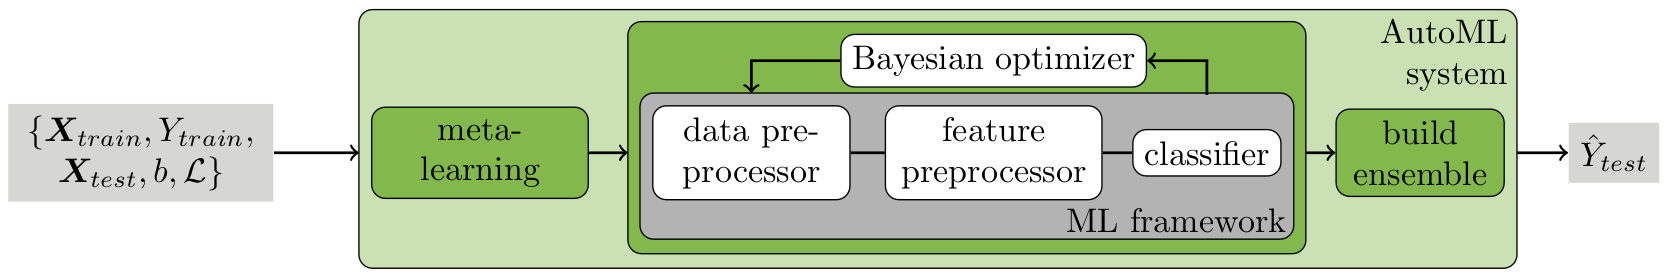


It is based on state-of-the-art AutoML technology and the well-known [scikit-learn](https://scikit-learn.org/stable/) library to provide **hands-free machine learning**.

<a name="setup"></a>
# 1. Setup

### 1a) Install Auto-sklearn

In order to run this code, we are going to first install Auto-sklearn using pip. For more instructions on how to install Auto-sklearn, for example using conda, please check [this](https://automl.github.io/auto-sklearn/master/installation.html).

**IMPORTANT: After installing all dependencies you need to restart the COLAB runtime (`Runtime` -> `Restart Runtime`) to have access to the newly installed packages!**

In [ ]:
!pip uninstall --yes nvidia-ml-py3
!pip uninstall --yes pandas-profiling
!pip uninstall --yes scipy
!pip install pandas-profiling
!pip install auto-sklearn==0.15.0

❗**Reminder: Restart the notebook before proceeding**

### 1b) Load Data and Define a Scoring Function

We will use the [credit-g](https://www.openml.org/d/31) dataset throughout this session. This datasets is a **binary classification task** and classifies credit requests into `good` or `bad` based on attributes, e.g. `amount`, `credit history` and `purpose of the credit`. We score a model based on the area under the [ROC curve](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics).

For this, we download the data, immediately split off the test set and define a scoring function.

In [ ]:
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection

# From OpenML: https://www.openml.org/d/31
dataset_name = "credit-g"

def get_data_and_scoring_function(dataset_name):  
    X, y = sklearn.datasets.fetch_openml(dataset_name, as_frame=True, return_X_y=True)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X, y, random_state=42, stratify=y,
    )

    def scoring_function(estimator):        
        predictions = estimator.predict_proba(X_test)[:, 1]
        return sklearn.metrics.roc_auc_score(y_test, predictions)

    def train_scoring_function(estimator):        
        predictions = estimator.predict_proba(X_train)[:, 1]
        return sklearn.metrics.roc_auc_score(y_train, predictions)

    def get_test_data():
        return X_test, y_test

    return X_train, y_train, get_test_data, scoring_function, train_scoring_function

X_train, y_train, get_test_data, scoring_function, train_scoring_function = get_data_and_scoring_function(dataset_name)

print(f"Done downloading {dataset_name}")

### 1c) Setup Pandas

In [ ]:
import pandas as pd
pd.set_option('display.width', 120)

### 1d) Visualize Data (Optional) 

In [ ]:
complete_df = pd.concat([y_train, X_train], axis=1)

In [ ]:
complete_df.describe(include='all')

In [ ]:
import pandas_profiling
report = pandas_profiling.ProfileReport(complete_df, title="Pandas Profiling Report")
report

<a name="task1"></a>
# Task 1: Build your own pipeline (BYOP; 15 minutes)

❓ **Why:** Even if you use AutoML methods, you should still take some time to understand the data and the pipeline you're going to use.

📓 **What:** Build your own scikit-learn pipeline

  1. Pre-process categorical and continuous features (if necessary)
  2. Choose a model type and train a predictive model
  3. Compute the score for your model
  4. Discuss the questions below 🔽 with your team members

If you are not familiar with scikit-learn you can find further information in the [docs](https://scikit-learn.org/stable/modules/compose.html#pipeline-chaining-estimators) and [examples](https://scikit-learn.org/stable/auto_examples/index.html#pipelines-and-composite-estimators).

✅ **Outcome:** Questions to be discussed:

  1. Which model class have you used?
  2. What was your score?

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

In [ ]:
# Import estimator and preprocessors you need
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder

# Initialize your estimator
# Check the scikit-learn API for inspiration: https://scikit-learn.org/stable/supervised_learning.html
#------------------------- edit code here
estimator_gradboost = DummyClassifier()

# Design and fit the pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), X_train.dtypes == "category"),
        ('cont', 'passthrough', X_train.dtypes != "category"),
    ],
    remainder='passthrough',
)

pipeline_byop = Pipeline([
  ('preprocessor', preprocessor),
  ('gradboost', estimator_gradboost),
])
#-------------------------

pipeline_byop.fit(X_train, y_train) 

# Score the pipeline
performance_byop = train_scoring_function(pipeline_byop)
print(f"Train performance of my pipeline is {performance_byop}")

performance_byop = scoring_function(pipeline_byop)
print(f"Test performance of my pipeline is {performance_byop}")

<a name="task2"></a>
# Task 2: Auto-sklearn and Auto-sklearn 2.0 (ASKL; 20 minutes)

❓ **Why:** You just manually built a predictive pipeline that works (pretty well). Now you're ready to use Auto-sklearn and learn how it produces predictions. Can we automate **even more**? Introducing Auto-sklearn 2.0 which includes meta-learned `resampling-strategy` selection!

📓 **What:** Run Auto-sklearn on a dataset, credit-g
  1. Run Auto-sklearn. Make sure that everyone at your table runs Auto-sklearn with a different setting, e.g. `resampling_strategy`, `ensemble_size`, `metric`,  (for more see [here](https://automl.github.io/auto-sklearn/master/api.html))
  2. Now try AutoSklearn 2.0 with its automated `resampling_strategy` selection with the same settings.
  2. Inspect the statistics between the two versions. 
  3. Discuss the questions below 🔽 with your team members

✅ **Outcome:** While AutoML systems seemingly magically produce predictions, it is always a good to also understand how they work. Here are a few questions your boss, your client or your professor might ask you regarding using Auto-sklearn:

  * What pipelines were found? Was it better than your manual pipeline?
  * How many function evaluations did Auto-sklearn perform?
  * How did the different settings impact the result/statistics? 
  * How could it find good models with only so little time?
  * How did the train/test performances change between AutoSklearn and Autosklearn2.0?
  * What `resampling-strategy`'s did you consider, did AutoSklearn 2.0 agree?
  * How does the final ensemble differ from the ensemble constructed by Auto-sklearn 1.0? Bigger/smaller, models, hyperparameters?
  * When would **you** apply crossvalidation, holdout and/or successive halving?

➕ **A Few Notes On Debugging**

Not everything works at the first try. Here are a few recommendations for [debugging](http://www.phdcomics.com/comics/archive/phd011406s.gif): 

  * Check the statistics: `estimator_askl.sprint_statistics()`
  * Check the evaluated models: `estimator_askl.show_models()`
  * Check the logs: Click the 📁 icon on the left, navigate to `/tmp/` and open the relevant Auto-sklearn logs in one of the `autosklearn_tmp_*` folders)
  * If nothing helps, try restarting the runtime and notebook
  * Do a factory reset as a last resort

#### Task 2a: Fitting Auto-sklearn

In [ ]:
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.experimental.askl2 import AutoSklearn2Classifier
from autosklearn.metrics import roc_auc

In [ ]:
# Edit the settings to try in both AutoSklearn1 and AutoSklearn2
# Possibilities https://automl.github.io/auto-sklearn/master/api.html

#------------------------- edit code here
settings = {
  "time_left_for_this_task": 120,  # seconds
  "seed": 42,
  "metric": roc_auc,
  "n_jobs": 4,
}

# This will only be used by autosklearn 1 while autosklearn 2 will automatically
# select a strategy
resampling_strategy = "holdout"

#-------------------------

Auto-sklearn follows the scikit-learn API to specify how to run in parallel by providing the argument `n_jobs`. If `n_jobs >= 1` the respective number of cores is used, for `n_jobs is None` 1 core is used and for `n_jobs < 0` all available cores are used. If you set `n_jobs != 1`, run Auto-sklearn on your local machine and have [Bokeh](https://bokeh.org/) installed, you also get access to the [Dask dashboard](https://docs.dask.org/en/stable/diagnostics-distributed.html) which shows how the individual training jobs of Auto-sklearn are executed in a distributed fashion.

Lets train AutoSklearn 1.0 with these settings

In [ ]:
# Create and train an ensemble with AutoML 
# Auto-sklearn will ingest the pandas dataframe and detects column types
askl1 = AutoSklearnClassifier(
    **settings,
    resampling_strategy=resampling_strategy
)
askl1.fit(X_train, y_train, dataset_name="credit-g")

Now lets take a look at the summary statistics!

In [ ]:
from pprint import pprint

print(f"Auto-sklearn 1.0 | train = {train_scoring_function(askl1)} | test = {scoring_function(askl1)}")
print(f"Selected `resampling-strategy` = {askl1.resampling_strategy}")
print(f"Selected `resampling-strategy-arguments` = {askl1.resampling_strategy_arguments}")

# Some quick summary statistics
print(askl1.sprint_statistics())

# The leaderboard shows all the models during the optimization process,
# see this link for arguments if you want to see more!
# https://automl.github.io/auto-sklearn/master/api.html#autosklearn.classification.AutoSklearnClassifier.leaderboard
leaderboard = askl1.leaderboard(sort_by="model_id", ensemble_only=True)
print(leaderboard)

# Show all the models in the final produced ensemble
pprint(askl1.show_models())

# For compatibility with scikit-learn we implement `cv_results_`, but the output is pretty lengthy, so we leave this commented
# print(askl1.cv_results_)

Now lets use these same settings with AutoSklearn 2.0 but leave out the resampling strategy

In [ ]:
# Create and train AutoSklearn2.0 
askl2 = AutoSklearn2Classifier(**settings)
askl2.fit(X_train, y_train, dataset_name="credit_g")

In [ ]:
from pprint import pprint

print(f"Auto-sklearn 2.0 | train = {train_scoring_function(askl2)} | test = {scoring_function(askl2)}")
print(f"Selected `resampling-strategy` = {askl2.resampling_strategy}")
print(f"Selected `resampling-strategy-arguments` = {askl2.resampling_strategy_arguments}")

print(askl2.sprint_statistics())

leaderboard = askl2.leaderboard(sort_by="model_id", ensemble_only=True)
print(leaderboard)
pprint(askl2.show_models())
# print(askl2.cv_results_)

<a name="task3"></a>
# Task 3: Multi-objective Optimization with Auto-sklearn (MO-ASKL; 20min)

❓ **Why:** Your predictive pipeline works great and you can make predictions for new datasets. However, the [area under the curve of the receiver operating curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (`roc_auc`) actually combines two separate measures. Wouldn't it be better to optimize for different tradeoffs between them and select a point afterwards?

📓 **What:** Run Auto-sklearn in a multi-objective setting on the credit-g dataset

  1. Run Auto-sklearn optimizing for [precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) and [recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) by passing two metrics to Auto-sklearn.
  2. Inspect the statistics, especially the leaderboard, to see how the two metrics interact with each other. You can also viasualize the trade-offs in a 2d plot.
  3. Discuss the questions below 🔽 with your team members
  4. Have a look at the [ParEGO](https://www.cs.bham.ac.uk/~jdk/parego/) algorithm that powers multi-objective optimization in Auto-sklearn

✅ **Outcome:** When optimizing for more than one objective, the questions of interest will change:

  * What's the final test performance for the different metrics?
  * How much would you lose when in precision when picking the solution with maximal recall, and vice versa?
  * How do the different models trade off precision and recall?
  * How does the model optimized for roc_auc trade off the two objectives?
  * Could you automatically choose a model for deployment?

In [ ]:
import numpy as np

import autosklearn.classification
import autosklearn.metrics

# Precision and recall require encoding the positive/minority class as 1
# and the negative/majority class as 0:
y_train_01 = np.array([1 if val == "bad" else 0 for val in y_train])

# Create and train an ensemble with AutoML 
moo_askl = autosklearn.classification.AutoSklearnClassifier(
    #------------------------- edit code here
    time_left_for_this_task=120, # in seconds
    seed=1, 
    resampling_strategy='holdout',
    # https://automl.github.io/auto-sklearn/master/api.html#built-in-metrics
    metric=[autosklearn.metrics.precision, autosklearn.metrics.recall],
    n_jobs=4,
    delete_tmp_folder_after_terminate=False,
    #-------------------------
)
# Auto-sklearn ingests the pandas dataframe and detects column types
moo_askl.fit(X_train, y_train_01, dataset_name='credit-g')

In [ ]:
print(moo_askl.leaderboard(ensemble_only=False))

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

lb = moo_askl.leaderboard(ensemble_only=False)
for neg_precision, neg_recall in zip(lb["cost_0"], lb["cost_1"]):
    ax.scatter(1 - neg_precision, 1 - neg_recall, color="blue")

_ = ax.set_xlabel("Precision")
_ = ax.set_ylabel("Recall")
_ = ax.set_xlim((0, 1))
_ = ax.set_ylim((0, 1))
_ = ax.set_title("Validation performance of all models found by Auto-sklearn")

In [ ]:
# 1st, create a new figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# 2nd, get the test data
X_test, y_test = get_test_data()
y_test_01 = np.array([1 if val == "bad" else 0 for val in y_test])

# 3rd predict on the test data using the single-objective Auto-sklearn & plot perf
for single_objective_askl, askl_version in ((askl1, "Auto-sklearn 1.0"), (askl2, "Auto-sklearn 2.0")):
  single_objective_predictions = single_objective_askl.predict(X_test)
  single_objective_predictions = np.array([1 if val == "bad" else 0 for val in single_objective_predictions])
  single_objective_precision = sklearn.metrics.precision_score(y_test_01, single_objective_predictions)
  single_objective_recall = sklearn.metrics.recall_score(y_test_01, single_objective_predictions)

  ax.scatter(single_objective_precision, single_objective_recall, label=askl_version)

# 4th iterate all entries in the [Pareto front approximation](https://en.wikipedia.org/wiki/Pareto_front) 
# of the multi-objective Auto-sklearn optimization and plot them
to_plot = {"precision": [], "recall": []}
for ensemble in moo_askl.get_pareto_set():
    predictions = ensemble.predict(X_test)
    to_plot["precision"].append(sklearn.metrics.precision_score(y_test_01, predictions))
    to_plot["recall"].append(sklearn.metrics.recall_score(y_test_01, predictions))

ax.scatter(to_plot["precision"], to_plot["recall"], label="MOO")

# 5th Label the plot
_ = ax.set_xlabel("Precision")
_ = ax.set_ylabel("Recall")
_ = ax.set_xlim((0, 1))
_ = ax.set_ylim((0, 1))
_ = ax.legend()
_ = ax.set_title("Test performances of all models found by Auto-sklearn")

<a name="bonus1"></a>
# Bonus Task 1: Explainability

❓ **Why:** To understand what features are important for producing a prediction.

📓 **What:** Apply feature importance methods to Auto-Sklearn. Auto-sklearn behaves like a scikit-learn estimator and thus any method that works with an scikit-learn estimator also works with Auto-sklearn. The [`sklearn.inspection`](https://scikit-learn.org/stable/inspection.html) module offers some interesting features importance methods you can evaluate, and in this task you will use the permutation importance.

✅ **Outcome:** Discuss the questions below 🔽 with your team members


* Which features are important?
* Can Auto-sklearn's design space be restricted to provide only interpretable models?
* What other feature importance methods could be applied (blackbox or whitebox)?

In [ ]:
from sklearn.inspection import plot_partial_dependence, permutation_importance
import matplotlib.pyplot as plt
import numpy as np

**Note**: In order to compute meaningful explanations we need data that is distinct from the training data, in this case we re-purpose the test set. This will take roughly two minutes if you've used `resampling_strategy='cv'` and much less if you've used `resampling_strategy='holdout'`. If you have time, you can increase the number of repetitions to get more reliable feature importance scores. If applicable, you can also move from cross-validation to holdout to improve speed here.

While the code runs, you could for example [read up how feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html) works.

In [ ]:
def get_data_for_feature_importance():
    # From OpenML: https://www.openml.org/d/31
    X, y = sklearn.datasets.fetch_openml('credit-g', as_frame=True, return_X_y=True)
    _, X_test, _, y_test = sklearn.model_selection.train_test_split(
      X, y, random_state=42
    )
    return X_test, y_test

X_feature_importance, y_feature_importance,  = get_data_for_feature_importance()

r = permutation_importance(
    askl1, X_feature_importance, y_feature_importance,
    n_repeats=2, random_state=0, n_jobs=-1,
    scoring='roc_auc',
)

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sort_idx = r.importances_mean.argsort()
ax.boxplot(r.importances[sort_idx].T, labels=[X_train.columns[i] for i in sort_idx], vert=False)
fig.show()
plt.show()

##### Other explainers

* Can use anything that works with sklearn
* [SHAP](https://github.com/slundberg/shap) can only be used for datasets without categorical features and without missing values
* [sklearn's partial dependency](https://scikit-learn.org/stable/modules/partial_dependence.html) plots only work for datasets without categorical features and without missing values
* We have such examples in a [EuroPython tutorial notebook](https://github.com/automl/auto-sklearn-talks/blob/main/2021_07_28_EuroPython/Tutorial-Regression.ipynb) and the [Auto-sklearn examples](https://automl.github.io/auto-sklearn/master/examples/40_advanced/example_inspect_predictions.html)

<a name="bonus2"></a>
# Bonus Task 2: Extend Auto-sklearn (EXTEND; 20 minutes)

❓ **Why:** Learn how to adapt the Auto-sklearn design space and understand the consequences of doing so.

📓 **What:** Extend Auto-sklearn with your own parameterized model

  1. Implement the new component. Some ideas are
    1. Re-add a [scikit-learn model](https://scikit-learn.org/stable/supervised_learning.html) (for classification)
    2. [XGBoost](https://github.com/dmlc/xgboost)
    3. [LightGBM](https://lightgbm.readthedocs.io/en/latest/)
  2. Run auto-sklearn (restricted to only your component)
  3. Study the statistics
  3. Discuss the questions below 🔽 with your team members


✅ **Outcome:** We will ask you the following: 

  1. What component did you add?
  2. What's the score you obtained?
  3. What do you think happens to the meta-learning part of Auto-sklearn, i.e. the set of configuration Auto-sklearn uses to warmstart?

In [ ]:
# First implement your model. As a guideline, we provide a copy of: 
# https://github.com/automl/auto-sklearn/blob/master/autosklearn/pipeline/components/classification/adaboost.py
from ConfigSpace.configuration_space import ConfigurationSpace
from ConfigSpace.hyperparameters import UniformFloatHyperparameter, \
    UniformIntegerHyperparameter, CategoricalHyperparameter

from autosklearn.pipeline.components.base import AutoSklearnClassificationAlgorithm
from autosklearn.pipeline.constants import DENSE, UNSIGNED_DATA, PREDICTIONS, SPARSE

class MyNewModel(AutoSklearnClassificationAlgorithm):
    def __init__(self, n_estimators, learning_rate, algorithm, max_depth,
                random_state=None):
        # All hyperparameters are args
        #------------------------- edit code here
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.algorithm = algorithm
        self.random_state = random_state
        self.max_depth = max_depth
        self.estimator = None
        #-------------------------


    def fit(self, X, Y, sample_weight=None):
        # Fit the model
        #------------------------- edit code here
        import sklearn.ensemble
        import sklearn.tree

        self.n_estimators = int(self.n_estimators)
        self.learning_rate = float(self.learning_rate)
        self.max_depth = int(self.max_depth)
        base_estimator = sklearn.tree.DecisionTreeClassifier(max_depth=self.max_depth)

        estimator = sklearn.ensemble.AdaBoostClassifier(
            base_estimator=base_estimator,
            n_estimators=self.n_estimators,
            learning_rate=self.learning_rate,
            algorithm=self.algorithm,
            random_state=self.random_state
        )

        estimator.fit(X, Y, sample_weight=sample_weight)
        #-------------------------
        self.estimator = estimator
        return self

    def predict(self, X):
        if self.estimator is None:
            raise NotImplementedError
        return self.estimator.predict(X)

    def predict_proba(self, X):
        if self.estimator is None:
            raise NotImplementedError()
        return self.estimator.predict_proba(X)

    @staticmethod
    def get_properties(dataset_properties=None):
        #------------------------- edit code here (optional)
        return {'shortname': 'MAB',
                'name': 'My AdaBoost Classifier',
                'handles_regression': False,
                'handles_classification': True,
                'handles_multiclass': True,
                'handles_multilabel': False,
                'handles_multioutput': False,
                'is_deterministic': True,
                'input': (DENSE, SPARSE, UNSIGNED_DATA),
                'output': (PREDICTIONS,)}
        #-------------------------

    @staticmethod
    def get_hyperparameter_search_space(feat_type=None, dataset_properties=None):
        #------------------------- edit code here
        # https://automl.github.io/ConfigSpace/main/api/hyperparameters.html#advanced-types
        cs = ConfigurationSpace()

        n_estimators = UniformIntegerHyperparameter(
            name="n_estimators", lower=50, upper=500, default_value=50, log=False)
        learning_rate = UniformFloatHyperparameter(
            name="learning_rate", lower=0.01, upper=2, default_value=0.1, log=True)
        algorithm = CategoricalHyperparameter(
            name="algorithm", choices=["SAMME.R", "SAMME"], default_value="SAMME.R")
        max_depth = UniformIntegerHyperparameter(
            name="max_depth", lower=1, upper=10, default_value=1, log=False)

        cs.add_hyperparameters([n_estimators, learning_rate, algorithm, max_depth])
        #-------------------------
        return cs

In [ ]:
from autosklearn.pipeline.components.classification import ClassifierChoice

# Now you can add your component
autosklearn.pipeline.components.classification.add_classifier(MyNewModel)
for name in ClassifierChoice.get_components():
    # this should also print the name of your model
    print(name)
  
# Create and train an ensemble with AutoML 
estimator_askl_mod = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    seed=42, 
    resampling_strategy='cv',
    metric=autosklearn.metrics.roc_auc,
    # It is possible to run Auto-sklearn in parallel with additional components 
    # if these components are in separate modules and the components are 
    # imported when using auto-sklearn
    n_jobs=1,
    # above is same as before, but here we restrict the design space to your new model
    include={
        'classifier': [
            'MyNewModel',
        ]
    },
)
# Auto-sklearn ingests the pandas dataframe and detects column types
estimator_askl_mod.fit(X_train, y_train, dataset_name='credit-g')

In [ ]:
performance_askl = train_scoring_function(estimator_askl_mod)
print(f"Train Auto-Sklearn Classifier performance is {performance_askl}")
performance_askl = scoring_function(estimator_askl_mod)
print(f"Test Auto-Sklearn Classifier performance is {performance_askl}")